Any cleaning discovered in this notebook have been added to make_dataset.py as part of creating the final processed dataset.  

Features are incorporated into transforms.py and the pipeline in models.py

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime as dt
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("..")
from src.models import utils as uf
from src.data import utils as ud


plt.rcParams['figure.figsize'] = 12, 8

/Users/mjain/Dev_DoSomething/sms_project/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
df = pd.read_csv('../data/processed/gambit_sample_uncleaned.csv.gz', compression='gzip', parse_dates=[
    'most_recent_signup', 'most_recent_post'], infer_datetime_format=True)

In [4]:
df.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,post_type,age,length_of_membership_days,source,...,Education,Environment,Homelessness,Mental Health,Physical Health,Poverty,Relationships,Sex,Violence,Week Of Action
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,NaN,30.0,2588.0,phoenix,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,NaN,27.0,2764.0,sms,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,NaN,61.0,1491.0,sms,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,NaN,25.0,1488.0,sms,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,NaN,24.0,1488.0,sms,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.columns

Index(['northstar_id', 'target', 'num_signups', 'most_recent_signup',
       'num_rbs', 'most_recent_post', 'post_type', 'age',
       'length_of_membership_days', 'source', 'state', 'sms_status',
       'voter_registration_status', 'cio_status', 'Animals', 'Bullying',
       'Civic Action', 'Disasters', 'Discrimination', 'Education',
       'Environment', 'Homelessness', 'Mental Health', 'Physical Health',
       'Poverty', 'Relationships', 'Sex', 'Violence', 'Week Of Action'],
      dtype='object')

### Ensure no  null or duplicate rows

In [6]:
uf.print_null_vals(df)

,col,num_null,percent_null
0,northstar_id,0,0.000000
1,target,0,0.000000
2,num_signups,0,0.000000
3,most_recent_signup,842168,0.842168
4,num_rbs,0,0.000000
5,most_recent_post,970728,0.970728
6,post_type,970728,0.970728
7,age,229768,0.229768
8,length_of_membership_days,0,0.000000
9,source,9605,0.009605


Remove null values for state, source, and age.

In [7]:
df['voter_registration_status'].value_counts()

registration_complete    11041
uncertain                 5517
confirmed                 1728
unregistered              1702
ineligible                 273
Name: voter_registration_status, dtype: int64

In [8]:
df['cio_status'].value_counts()

customer_subscribed      626355
customer_unsubscribed    165590
Name: cio_status, dtype: int64

In [9]:
df['sms_status'].value_counts()

pending          802007
undeliverable    175465
active            16589
less               3440
unknown            1760
stop                704
GDPR                 28
Name: sms_status, dtype: int64

In [10]:
df = df[~(df['age'].isnull())]
df = df[~(df['state'].isnull() | (df['state'] == ''))]
df = df[~(df['source'].isnull())]
df = df[~(df['sms_status'].isnull() | (df['sms_status'].isin(['undeliverable', 'stop', 'GDPR'])))]

In [11]:
df.duplicated('northstar_id', keep=False).sum()

0

### Clean / encode categorical values
This will avoid null values or having to impute for users that have no activity for the following variables. 

<b> Cio Status </b>

Set null values to unsubscribed.

In [12]:
df.loc[df['cio_status'].isnull() | (df['cio_status'] == '0'), 'cio_status'] = 'customer_unsubscribed'

In [13]:
df = pd.merge(
    df, pd.get_dummies(df.set_index('northstar_id')['cio_status'], prefix='cio_status'), on='northstar_id').drop(
    columns=['cio_status'])

<b> Voter Registration </b>

Set null values to not registered. Condense values to binary registered/not registered since other classes not large enough.

In [14]:
df.loc[
    (df['voter_registration_status'].isnull() | (df['voter_registration_status'].isin(['ineligible', 'uncertain']))),
    'voter_registration_status'] = 'unregistered'

In [15]:
df.loc[
    df['voter_registration_status'].isin(['registration_complete', 'confirmed']), 
    'voter_registration_status'] = 'registered'

In [16]:
df['voter_registration_status'].value_counts()

unregistered    606764
registered        9759
Name: voter_registration_status, dtype: int64

In [17]:
df = pd.merge(
    df, pd.get_dummies(df.set_index('northstar_id')['voter_registration_status'], prefix='voter_registration_status'),
    on='northstar_id').drop(
    columns=['voter_registration_status'])

<b> SMS Status </b>

In [18]:
df = pd.merge(
    df, pd.get_dummies(df.set_index('northstar_id')['sms_status'], prefix='sms_status'), on='northstar_id').drop(
    columns=['sms_status'])

<b> Activity Level </b>    

1. Find most recent activity. 
2. Convert to categorical (null = never acted; not null + > 90 days = less active, not null + < 90 days = active)

In [19]:
df['activity_level'] = df.apply(uf.find_activity_level, last_active=90, axis=1)

In [20]:
df.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,post_type,age,length_of_membership_days,source,...,Week Of Action,cio_status_customer_subscribed,cio_status_customer_unsubscribed,voter_registration_status_registered,voter_registration_status_unregistered,sms_status_active,sms_status_less,sms_status_pending,sms_status_unknown,activity_level
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,NaN,30.0,2588.0,phoenix,...,0.0,1,0,0,1,0,0,1,0,less_recent_action
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,NaN,27.0,2764.0,sms,...,0.0,0,1,0,1,0,0,1,0,no_action
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,NaN,61.0,1491.0,sms,...,0.0,0,1,0,1,0,0,1,0,no_action
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,NaN,25.0,1488.0,sms,...,0.0,0,1,0,1,0,0,1,0,no_action
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,NaN,24.0,1488.0,sms,...,0.0,0,1,0,1,0,0,1,0,no_action


In [21]:
df_user_activity = pd.merge(
    df, pd.get_dummies(df.set_index('northstar_id')['activity_level']), on='northstar_id').drop(
    columns=['activity_level'])

In [22]:
df_user_activity.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,post_type,age,length_of_membership_days,source,...,cio_status_customer_unsubscribed,voter_registration_status_registered,voter_registration_status_unregistered,sms_status_active,sms_status_less,sms_status_pending,sms_status_unknown,less_recent_action,no_action,recent_action
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,NaN,30.0,2588.0,phoenix,...,0,0,1,0,0,1,0,1,0,0
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,NaN,27.0,2764.0,sms,...,1,0,1,0,0,1,0,0,1,0
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,NaN,61.0,1491.0,sms,...,1,0,1,0,0,1,0,0,1,0
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,NaN,25.0,1488.0,sms,...,1,0,1,0,0,1,0,0,1,0
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,NaN,24.0,1488.0,sms,...,1,0,1,0,0,1,0,0,1,0


<b> Post type </b>

In [23]:
df_user_activity = pd.merge(
    df_user_activity, pd.get_dummies(df_user_activity.set_index('northstar_id')['post_type']), on='northstar_id').drop(
    columns=['post_type'])

In [24]:
df_user_activity.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,age,length_of_membership_days,source,state,...,sms_status_less,sms_status_pending,sms_status_unknown,less_recent_action,no_action,recent_action,photo,share-social,text,voter-reg
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,30.0,2588.0,phoenix,NY,...,0,1,0,1,0,0,0,0,0,0
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,27.0,2764.0,sms,NY,...,0,1,0,0,1,0,0,0,0,0
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,61.0,1491.0,sms,NC,...,0,1,0,0,1,0,0,0,0,0
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,25.0,1488.0,sms,NJ,...,0,1,0,0,1,0,0,0,0,0
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,24.0,1488.0,sms,MN,...,0,1,0,0,1,0,0,0,0,0


<b> User source </b>

In [25]:
df_user_activity['source'].value_counts()

niche                   295765
phoenix                 169251
sms                     110293
phoenix-oauth            34160
phoenix-next              6731
voting_app                 180
teenlife                    31
northstar                   27
mobileapp_ios               23
niche-import-service        21
hercampus                   14
att-ichannel                10
mobileapp_android            9
mailchimp                    5
drupal                       2
letsdothis-ios               1
Name: source, dtype: int64

In [26]:
# group the lower counts to 'other' 
df_user_activity.loc[~df_user_activity['source'].isin(
    ['phoenix', 'sms', 'niche', 'phoenix-next', 'phoenix-oauth']), 'source'] = 'other' 

In [27]:
df_user_activity['source'].value_counts()

niche            295765
phoenix          169251
sms              110293
phoenix-oauth     34160
phoenix-next       6731
other               323
Name: source, dtype: int64

In [28]:
df_user_activity = pd.merge(
    df_user_activity, pd.get_dummies(df_user_activity.set_index('northstar_id')['source'], prefix='source'), 
    on='northstar_id').drop(
    columns=['source'])

In [29]:
df_user_activity.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,age,length_of_membership_days,state,Animals,...,photo,share-social,text,voter-reg,source_niche,source_other,source_phoenix,source_phoenix-next,source_phoenix-oauth,source_sms
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,30.0,2588.0,NY,0.0,...,0,0,0,0,0,0,1,0,0,0
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,27.0,2764.0,NY,0.0,...,0,0,0,0,0,0,0,0,0,1
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,61.0,1491.0,NC,0.0,...,0,0,0,0,0,0,0,0,0,1
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,25.0,1488.0,NJ,0.0,...,0,0,0,0,0,0,0,0,0,1
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,24.0,1488.0,MN,0.0,...,0,0,0,0,0,0,0,0,0,1


<b> State </b>

In [30]:
df_user_activity['state'].value_counts()[-90:-50]

Pa                1
{value: SD}       1
Toa               1
AZ - Arizona      1
San               1
North carolina    1
D.C.              1
Virginia (VA)     1
ILLINOIS          1
Minnesota         1
utah              1
Ohio OH           1
{value: OR}       1
Unat              1
Gyeo              1
Texas TX          1
Jian              1
Oregon            1
Ms                1
md                1
Sono              1
iowa              1
Il                1
mass              1
Fl                1
Illinios          1
--Select--N.J.    1
Wisc              1
NJ                1
South Dakota      1
kansas            1
INDIANA           1
NV                1
IST               1
South carolina    1
Flordia           1
{value: WV}       1
Rhode island      1
Mississippi MS    1
Baytown           1
Name: state, dtype: int64

In [31]:
df_user_activity['state'] = df_user_activity['state'].str.upper()
df_user_activity['state'] = df_user_activity['state'].str.strip()
df_user_activity['state'] = df_user_activity['state'].str.replace(r'{VALUE: ', '')
df_user_activity['state'] = df_user_activity['state'].str.replace(r'}| -', '')

In [32]:
df_user_activity['state'].value_counts()[-50:]

INDI                 1
YUCA                 1
LA.                  1
VICT                 1
BAYTOWN              1
ILLINIOS             1
NEW MEXICO           1
TENN                 1
MARYLANG             1
MISSISSIPPI MS       1
WAIK                 1
BEIJ                 1
AGS                  1
UNITED STATES        1
DHAK                 1
ENGL                 1
NORTH CAROLINA NC    1
SAN                  1
OVER                 1
SULA                 1
PEE DEE              1
D.C.                 1
PENNSYLVANNIA        1
GYEO                 1
BALO                 1
TEXAS TX             1
.                    1
RIVERSIDE            1
LOUISISANA           1
FL.                  1
GY?R                 1
VERMONT              1
UNAT                 1
MS MISSISSIPPI       1
OHIO OH              1
CALIFORNIA CA        1
UNIT                 1
CESA                 1
COOR                 1
TOA                  1
ACCR                 1
CALI                 1
JIAN                 1
VIRGINIA (V

In [33]:
df_user_activity['state'] = df_user_activity['state'].apply(ud.map_state_to_abbrev)

In [34]:
df_user_activity['state'].value_counts()[-20:]

IA    3829
NM    3635
NE    3212
ID    2767
HI    2604
WV    1966
NH    1934
DE    1683
DC    1676
ME    1540
RI    1499
MT    1200
SD    1061
PR    1023
AK     850
ND     790
WY     770
VT     542
VI       2
FM       1
Name: state, dtype: int64

In [35]:
df_user_activity[df_user_activity['state'].isnull()].head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,age,length_of_membership_days,state,Animals,...,photo,share-social,text,voter-reg,source_niche,source_other,source_phoenix,source_phoenix-next,source_phoenix-oauth,source_sms
1682,554acc7e469c64bf3d8b5bb9,0,0.0,NaT,0.0,NaT,27.0,1516.0,None,0.0,...,0,0,0,0,0,0,1,0,0,0
5918,5567563d469c6416048b8e52,0,0.0,NaT,0.0,NaT,21.0,1341.0,None,0.0,...,0,0,0,0,0,0,1,0,0,0
11181,557cfe87469c64f4768b6d05,0,0.0,NaT,0.0,NaT,22.0,3423.0,None,0.0,...,0,0,0,0,0,0,0,0,0,1
17244,559d5ab7469c64f43e8b88de,0,0.0,NaT,0.0,NaT,21.0,1372.0,None,0.0,...,0,0,0,0,0,0,0,0,0,1
20932,55a732f3469c64022e8c7587,0,0.0,NaT,0.0,NaT,26.0,3442.0,None,0.0,...,0,0,0,0,0,0,1,0,0,0


In [36]:
df_user_activity = df_user_activity[~(df_user_activity['state'].isnull())]

In [37]:
df_user_activity.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,age,length_of_membership_days,state,Animals,...,photo,share-social,text,voter-reg,source_niche,source_other,source_phoenix,source_phoenix-next,source_phoenix-oauth,source_sms
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,30.0,2588.0,NY,0.0,...,0,0,0,0,0,0,1,0,0,0
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,27.0,2764.0,NY,0.0,...,0,0,0,0,0,0,0,0,0,1
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,61.0,1491.0,NC,0.0,...,0,0,0,0,0,0,0,0,0,1
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,25.0,1488.0,NJ,0.0,...,0,0,0,0,0,0,0,0,0,1
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,24.0,1488.0,MN,0.0,...,0,0,0,0,0,0,0,0,0,1


<b> Region </b>

In [38]:
df_user_activity['region'] = df_user_activity['state'].apply(uf.map_region_to_state)

In [39]:
df_user_activity.head()

,northstar_id,target,num_signups,most_recent_signup,num_rbs,most_recent_post,age,length_of_membership_days,state,Animals,...,share-social,text,voter-reg,source_niche,source_other,source_phoenix,source_phoenix-next,source_phoenix-oauth,source_sms,region
0,54fa272b469c64d7068b4567,0,1.0,2018-05-15 19:25:41,0.0,NaT,30.0,2588.0,NY,0.0,...,0,0,0,0,0,1,0,0,0,MIDDLE ATLANTIC
1,54fa272b469c64d8068b4568,0,0.0,NaT,0.0,NaT,27.0,2764.0,NY,0.0,...,0,0,0,0,0,0,0,0,1,MIDDLE ATLANTIC
2,54fa272b469c64d8068b456b,0,0.0,NaT,0.0,NaT,61.0,1491.0,NC,0.0,...,0,0,0,0,0,0,0,0,1,SOUTH
3,54fa272c469c64d7068b456d,0,0.0,NaT,0.0,NaT,25.0,1488.0,NJ,0.0,...,0,0,0,0,0,0,0,0,1,MIDDLE ATLANTIC
4,54fa272c469c64d7068b456e,0,0.0,NaT,0.0,NaT,24.0,1488.0,MN,0.0,...,0,0,0,0,0,0,0,0,1,MIDWEST


In [40]:
df_user_activity = pd.merge(
    df_user_activity, pd.get_dummies(df_user_activity.set_index('northstar_id')['region']), on='northstar_id').drop(
    columns=['region', 'state'])

<b> Age </b>

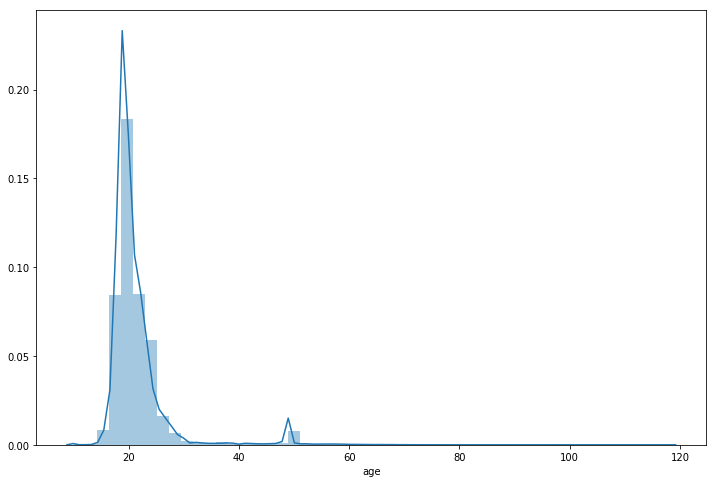

In [41]:
sns.distplot(df_user_activity['age']);

In [42]:
len(df_user_activity[df_user_activity['age'] > 50])

3704

In [43]:
df_user_activity = df_user_activity[~(df_user_activity['age'] > 50)]

### Look at feature correlation

In [44]:
df_user_activity.columns

Index(['northstar_id', 'target', 'num_signups', 'most_recent_signup',
       'num_rbs', 'most_recent_post', 'age', 'length_of_membership_days',
       'Animals', 'Bullying', 'Civic Action', 'Disasters', 'Discrimination',
       'Education', 'Environment', 'Homelessness', 'Mental Health',
       'Physical Health', 'Poverty', 'Relationships', 'Sex', 'Violence',
       'Week Of Action', 'cio_status_customer_subscribed',
       'cio_status_customer_unsubscribed',
       'voter_registration_status_registered',
       'voter_registration_status_unregistered', 'sms_status_active',
       'sms_status_less', 'sms_status_pending', 'sms_status_unknown',
       'less_recent_action', 'no_action', 'recent_action', 'photo',
       'share-social', 'text', 'voter-reg', 'source_niche', 'source_other',
       'source_phoenix', 'source_phoenix-next', 'source_phoenix-oauth',
       'source_sms', 'MIDDLE ATLANTIC', 'MIDWEST', 'NEW ENGLAND', 'SOUTH',
       'SOUTHWEST', 'WEST'],
      dtype='object')

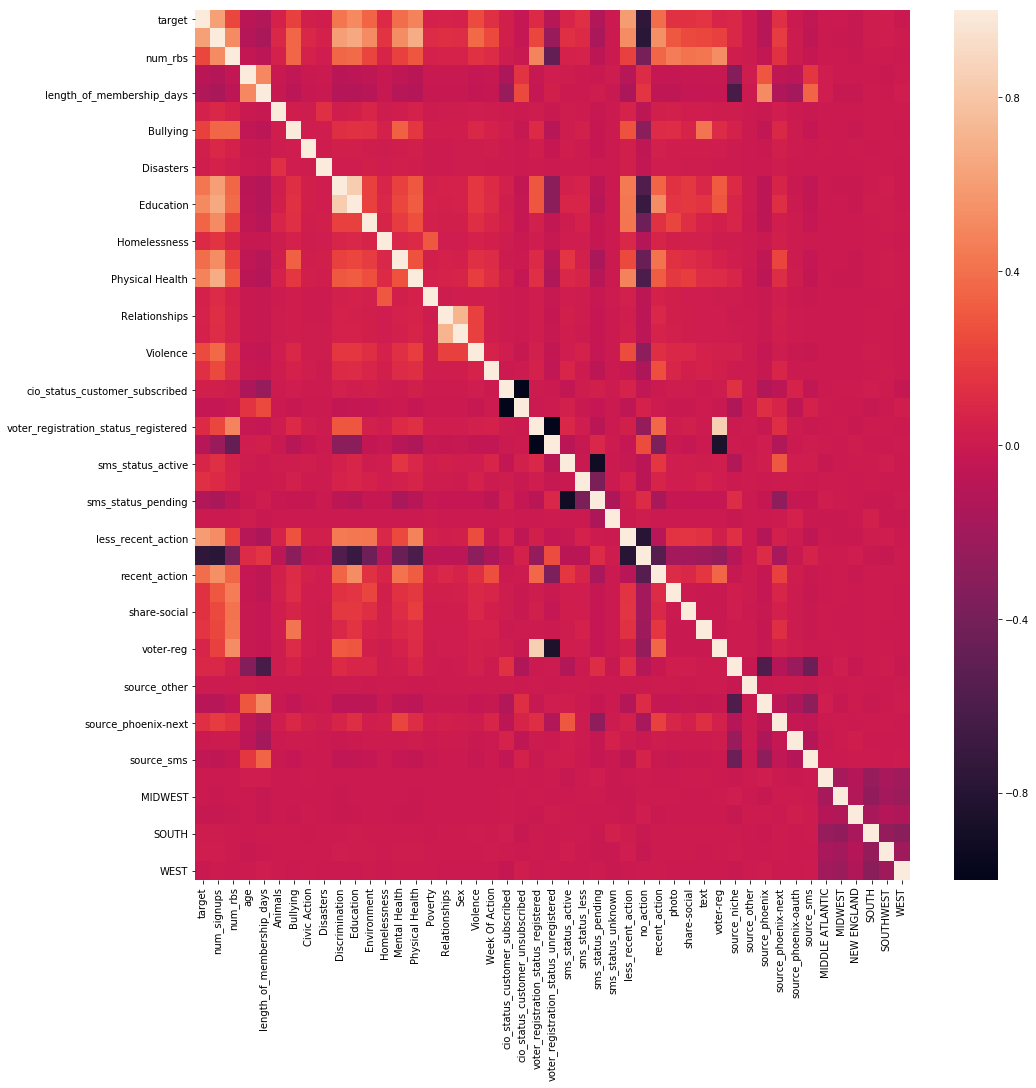

In [45]:
fig1, ax1 = plt.subplots()
sns.heatmap(df_user_activity[1:].corr(), ax=ax1)
fig1.set_size_inches(16, 16)

Check if dataset processed via script aligns.

In [46]:
df_check = pd.read_csv('../data/final/gambit_sample_cleaned.csv.gz', compression='gzip')

In [47]:
len(df_check), len(df_user_activity)

(612728, 612728)

Visualize active vs. inactive members across features.

In [48]:
df_active = df_user_activity[df_user_activity['target'] == 1]

In [49]:
df_inactive = df_user_activity[df_user_activity['target'] == 0]

In [50]:
columns = list(df_user_activity.columns[6:]) + ['num_signups', 'num_rbs']

In [ ]:
for col in columns:
    fig, ax = plt.subplots()
    sns.distplot(df_active[col], ax=ax, label='active')
    sns.distplot(df_inactive[col], ax=ax, label='inactive')
    ax.legend()